In [50]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

import math
import numpy
import pandas

# Exercise 1

Other than speed, what other measures of efficiency might one use in a real-world setting?

# Exercise 2
For inputs of size `n`, insertion sort runs in `8n^2` steps, while merge sort runs in `64 n log(n)`.

For which values of `n` does insertion sort beat merge sort?

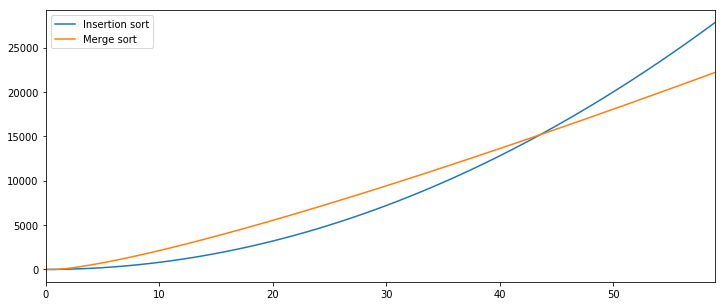

In [51]:
def insertion_sort_complexity(n):
    return 8*(n**2)
def merge_sort_complexity(n):
    if n == 0:
        return 0
    return 64*n*math.log(n, 2)

N = 60
series = {
    'Insertion sort': list(insertion_sort_complexity(n) for n in range(N)),
    'Merge sort': list(merge_sort_complexity(n) for n in range(N)),
}
f = pandas.DataFrame(data=series)
f.plot()

# Exercise 3
What is the smallest value of `n` such that an algorithm whose running time is `100 n^2` faster than an algorithm whose running time is `2^n` on the same machine?

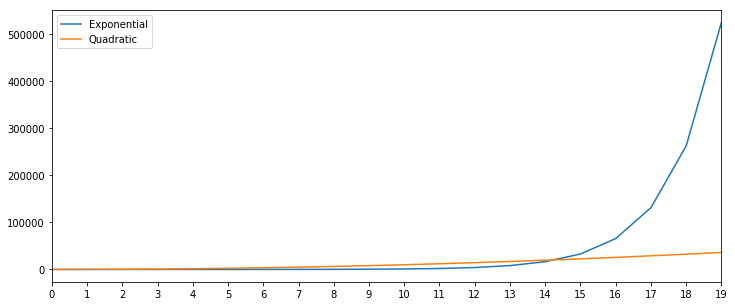

In [52]:
def quadratic(n):
    return 100*n**2
def exponential(n):
    return math.pow(2, n)

N = 20
series = {
    'Quadratic': list(quadratic(n) for n in range(N)),
    'Exponential': list(exponential(n) for n in range(N)),
}
df = pandas.DataFrame(data=series)
df.plot(xticks=range(N))

# Exercise 4

Consider the searching problem:

**Input**: A sequence of `n` numbers: `A = a_1, a_2, …, a_n` and a value `v`

**Output**: An index `i` such that `v = A[i]`, or the special value `NIL` if `v` does not appear in `A`.

Write pseudocode for linear search, which scans through the sequence, looking for `v`. Using a loop invariant, prove that the algorithm is correct. Make sure your loop invariant fulfills the three necessary properties.

In [78]:
def find_value(A, v):
    for i in range(0, len(A)):
        if A[i] == v:
            return i
    return None

(-834, None, None)

In [93]:
import random

# Built-in index() function of Python lists is our definition of truth, an oracle
def oracle_find(A, v):
    try:
        return A.index(v)
    except ValueError:
        return None # not found

# Make it semi-likely that v exists in L
def generate_input():
    N = 1000
    def rand():
        return random.randint(-N, N)

    v = rand()
    L = list(rand() for n in range(N*2))
    return (L, v)
    
def verify_result(L, v, index):
    if index is not None:
        # Invariant: A[i] = v
        assert L[index] == v 
    else:
        # Invariant: NIL -> v does not exist in L
        assert v not in L

    i_oracle = oracle_find(L, v)
    assert i_oracle == index

def test():
    A, v = generate_input()
    i_ours = find_value(A, v)
    verify_result(A, v, i_ours)
    return ("not in A" if i_ours is None else "%d == %d: %s" % (A[i_ours], v, A[i_ours] == v) )
    
list(test() for i in range(0, 100))[:10]

['271 == 271: True',
 '319 == 319: True',
 'not in A',
 'not in A',
 'not in A',
 'not in A',
 '-852 == -852: True',
 '-122 == -122: True',
 '294 == 294: True',
 '352 == 352: True']

In [ ]:
# Fault injection
